In [1]:
#Libraries imports
import torch
import edward
from edward.models import OneHotCategorical, Mixture, Normal
import pandas as pd
from sklearn.metrics import mean_squared_error
import time
import numpy as np
import random
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#Load test data and necessary data for prediction inspection

with open('/tmp/PredictionPDF.pt','rb') as f:
         probs = torch.load(f)
#with open('/tmp/PDFCenters.pt','rb') as f:
#         centers = torch.load(f)
with open('../data/Wall/test_data_2sensors_1hot.pt','rb') as f:
      test_ = torch.load(f)


#Load N test points
N = 10
test_data = test_[random.sample(range(0, len(test_)), N),:] 

In [3]:
#Inspect posterior predictive distribution

y_post = []
sigma_y = 1.0
n_samples = 200


t0 = time.time()
for i in xrange(N):
    print("Forming the posterior predictive distribution for test data point", i+1, "/", len(test_data), "...")
    y_post.append(OneHotCategorical(probs = probs[i]))
    
print("Took altogether", np.int(time.time() - t0), "secs.")

t0 = time.time()                                                                                                                                                                                                                                                                                                                                                                                                                                                            
print("Sampling the posterior predictive distribution for", len(test_data), "test data points...")
posteriorsamplenodes = tf.stack([y_post[i].sample(n_samples) for i in range(N)], axis=1)
#Posterior samples contain n_samples samples from each posterior predictive distribution, shape = n_samples x N
psnodes = np.zeros((n_samples,N))
with tf.Session().as_default():
     for i in xrange(N):
        psnodes[:,i] = np.argmax(y_post[i].sample(n_samples).eval(),axis=1)
     
     posteriorsamples = pd.DataFrame(psnodes)
    
print(posteriorsamples)
print("Took", np.int(time.time() - t0), "secs.")

('Forming the posterior predictive distribution for test data point', 1, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 2, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 3, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 4, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 5, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 6, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 7, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 8, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 9, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 10, '/', 10, '...')
('Took altogether', 0, 'secs.')
('Sampling the posterior predictive distribution for', 10, 'test data points.

In [4]:
#Inspect prediction statistics

#Predictions are the mean over the #n_samples predicted values for each test data point
predictions = posteriorsamples.mean()
predictions_low = posteriorsamples.quantile(0.01)
predictions_high = posteriorsamples.quantile(0.99)

results = pd.DataFrame()
results['Bayesian_prediction'] = predictions    
results['Bayesian_prediction_low'] = predictions_low
results['Bayesian_prediction_high'] = predictions_high

#Results contain the accuracy of the predictions on the test data points
print("Accuracy on test data for Bayesian neural network:")
print(len(np.where(results['Bayesian_prediction']==np.argmax(test_data[:,2:6],axis=1))[0])/float(len(test_data[:,2]))*100)
results

Accuracy on test data for Bayesian neural network:
10.0


,Bayesian_prediction,Bayesian_prediction_low,Bayesian_prediction_high
0,2.000,2.0,2.0
1,2.000,2.0,2.0
2,2.000,2.0,2.0
3,2.000,2.0,2.0
4,2.000,2.0,2.0
5,2.310,0.0,3.0
6,2.000,2.0,2.0
7,2.000,2.0,2.0
8,0.450,0.0,3.0
9,0.015,0.0,0.0


4
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2.]


Text(0.5,1,'Results for test data point 4')

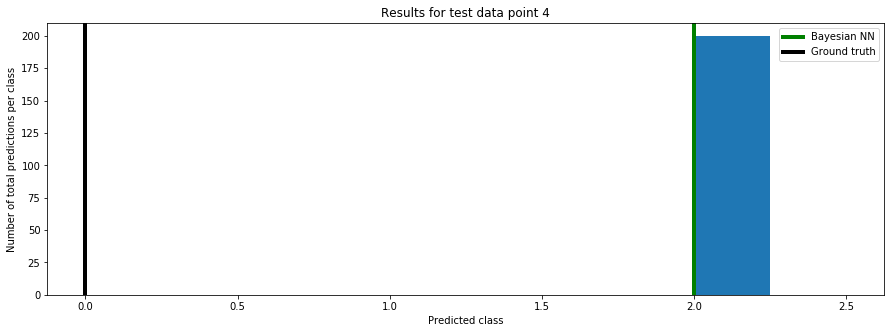

In [9]:
#Visualise one (random) prediction and associated uncertainty

test_sample_number = np.random.choice(range(len(test_data)))
print(test_sample_number)
print((posteriorsamples[test_sample_number].values))
plt.figure(figsize=(15,5))

_, _, histogram = plt.hist(posteriorsamples[test_sample_number].values, bins=4, density=False)
plt.xlabel("Predicted class")
plt.ylabel("Number of total predictions per class")
plt.axvline(results.loc[test_sample_number, 'Bayesian_prediction'], color='g', linewidth=4, label="Bayesian NN")
plt.axvline(test_data[test_sample_number,2], color='k', linewidth=4, label="Ground truth")
plt.legend()
plt.title("Results for test data point " + str(test_sample_number))